# Case Study 1: Predicting Location via Indoor Positioning Systems (IPS)
## MSDS 7333: Quantifying the World
### Andy Nguyen, Michael Wolfe, Josepha Caguioa

## Objective
The floor plan for the building shows six access points. However, the data contain seven access points with roughly the expected number of signals (166 location 8 orientations 110 replications 146,080 measurements). Two of the MAC addresses seem to be for the same access point. Measurements from the MAC address 00:0f:a3:39:e1:c0 were kept while measurements to the 00:0f:a3:39:dd:cd address were eliminated. Conduct a more thorough data analysis into these two MAC addresses. Did we make the correct decision? Does swapping out the one we kept for the one we discarded improve the prediction?

### Guidelines

Using the OFFLINE data and **2 different clustering methods**, predict the location of the ONLINE dataset.

1. Describe how you prepared the data.
2. Describe how you estimated your error and found the best fit ASSUMING you CANNOT USE THE ONLINE DATA. Use tables and/or charts with analysis.
3. Describe the best fit for the data using tables and/or charts with analysis.
4. There are 2 macIDs located at the same position (the researchers used 00:0f:a3:39:e1:c0 and excluded 00:0f:a3:39:dd:cd for their analysis). Does one give better performance than the other?
    * Note: to effectively answer the below, you’d need to run (3) different scenarios (this aligns to question 9 from the text; page 41)
5. What about using them both? (compare the result of “c0 & cd” against “c0-only” and “cd-only”)
6. What are the drawback (if any of using this method to real-time locate an object)?
7. Describe a method that may be an improvement based on your perceived drawbacks.


**Datasets** <br>
http://rdatasciencecases.org/Data/offline.final.trace.txt <br>
http://rdatasciencecases.org/Data/online.final.trace.txt


### Data Description

Indoor positioning systems (IPS) use WiFi signals from network access points within a wireless local area network (LAN) to track people and objects inside stores, warehouses, hospitals, and factories. The system requires a reference data set that contains signal strength measurements between wireless mobile devices (i.e. cellular phone, laptop, etc.) and fixed access points (i.e. routers) at known locations within the test environment. A model for the location can then be trained as a function of the signal strengths between the devices and each access point. This model can then be used to predict the locations of new, unknown devices based on the detected signals for the device.

The data used in this analysis was collected from a test environment at the University of Mannheim. Signal strengths were measured using a hand-held device at 166 different locations spaced 1 meter apart in the hallway of one floor of the building. The floor plan [Figure 1] measures 15 x 36 meters and is displayed below with signal strength measurements of mobile devices denoted as **gray dots** and fixed Wifi router access points denoted as **black squares**. Each reference location is positioned at an x,y coordinate and were each recorded in 45 degree increments for 8 different orientations. For each of the location-orientation combinations, 110 signal strength measurements were recorded. However, it is important to note that not all signal strengths were measured at every location, and that measurememnts from other mobile devices in the ambient vicinity of the experimental environment also appear.

The reference data is also referred to as the offline data set, and the data containing detected signals for new unknown devices will be referred to as the online data set. There are also 110 signal strengths similarly measured for each location-orientation combination, but at only 60 sampled locations in the online test data. These positions are denoted as **black dots** in [Figure 1] of the floor plan. 

The indoor positioning system will be built by training a model on the offline data based on reference locations to provide calibrated signal strength measurements at those positions. The model will then be used to prediction the positions of wireless mobile devices at uncalibrated positions in the online data.

<figure class ="image">
<center>
    <img src = "http://www.rdatasciencecases.org/GeoLoc/images/building.png">
    <figcaption id = "Figure 1"> Figure 1: Floor Plan of Test Environment </figcaption>
</center>
</figure>
<br>

### Pre-Process Data

Both the online and offline raw data are stored as text files. In order to process the data, the files were parsed at each line to separate data features at semi-colon and comma delimiters. Data entry values were extracted by parsing the file at equal sign delimiters. Lines that were comments in text file were removed from the data.

The 8 orientations were designed to be measured at 45 degree intervals, but the orietnation are not exact (i.e. 45.2 degrees instead of 45). Thus, values for the orientation were rounded and mapped to correspond to these 8 equi-spaced angles in the data processing steps. (i.e. 0, 45, 90, 135, etc.) Note that orientation values of 360 degrees are mapped to 0 for consistency.

Since only fixed access point device types will be analyzed in the context of this study, "adhoc" device measurements corresponding to type = 1 were dropped. This results in only 1 device type in the data so the "type" feature was also removed.

The scanMac variable was also discarded because there is only one corresponding value and will not add data variability to our analysis. This was the MAC address for the hand-held device from which signal measurements were recorded. Similarly, the posZ feature was also dropped since all signal strength measurements were taken on a single floor of the building. This means that the elevation of the devices are all the same at a value of 0, and will not add variability in our analysis.

Furthermore, the raw data measured signal strengths from 12 MAC addresses and 8 channels. The data documentation noted that signals from other mobile devices were also detected within the ambient environment. The data exploration showed that the number of signal measurements significantly dropped off after the top 7 MAC addresses despite the floor plan test environment containing only 6 access points. The assumption is that two MAC addresses correspond to the same access point (00:0f:a3:39:dd:cd & 00:0f:a3:39:e1:c0). The top 7 MAC addresses are retained in order to explore this analomy between these 2 MAC addresses.

Following the processing of MAC addresses, the MAC address and channel combinations show a one-to-one correlation. Thus, we can remove the channel variable from our data as well.

The features were then converted to the appropriate data types. An additional time feature containing a formatted time stamp was also included in the data after transforming the rawTime for easier human-readability and interpretation. However, this format resulted in a lost of percision as the time stamp format is on the seconds scale while the rawTime is on the milliseconds scale. This processed data was then outputted and saved as a csv file to be read into Python for analysis.

These data processing steps were performed in R, but model training and predictions will be conducted in Python. Once loaded into Python, the data was processed further to cast the time variable as a date-time object. The dataframe was then cast into a wide format to have the signal strength measurements corresponding to each MAC addresses as column features. These was done by indexing on the rawTime for its milliseconds precision and results in 146,074 rows and 11 column features. This is approximately the expected number of measurments for 110 signals, 166 positions, and 8 orientations (146,080).

The online data was processed the same way in R, but was indexed on x-y coordinate position labels once loaded into Python. This results in 60 rows that represent the 60 unknown locations to be predicted by the models. The location-orientation combinations are not considered in the online data since exploratory data analysis showed that the signal strengths were only recorded at one orientation for each location.

In [1]:
import rpy2.ipython
%load_ext rpy2.ipython

In [2]:
%%time
%%R 
# DO NOT NEED TO RUN THIS CELL IF FILE ALREADY EXITS IN WORKING DIRECTORY

library(tidyverse)
library(magrittr)
# Parser Function that returns matricies of measured signal strengths
processLine = 
  function(x) {
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
  }

roundOrientation = 
  function(angles) {
  refs = seq(0, by = 45, length = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
  }

processData = 
  function(filename)
  { # read in data from file
    txt = readLines(filename)
    # subset original offline text data to remove all lines with comments
    lines = txt[ substr(txt, 1, 1) != "#" ]
    # apply parser function to every line in the text file
    tmp = lapply(lines, processLine)
    # cast parsed data into data frame 
    data = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    # assign variable names to data features
    names(data) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
    # Remove all adhoc type measurements from data frame
    # Analysis will only include signal strengths measured to fixed access points
    data = data[ data$type == "3", ]
    
    # Drop scanMac, posZ, channel, and type (contain no useful info)
    # only 1 value for scanMac, the MAC for the hand-held device
    # posZ = 0 for all measurements since they were all taken on the same floor
    dropVars = c("scanMac", "posZ", "channel", "type")
    data = data[ , !( names(data) %in% dropVars ) ]
    
    # There are 12 unqiue MAC addresses and 8 channels
    # keep records from top 7 devices, since there is a large drop in number of signals after (>100,000)
    # channels removed b/c one-to-one correspondence between MAC addresses and channels for remaining 7 devices
    keepMacs = names(sort(table(data$mac), decreasing = TRUE))[1:7]
    data = data[ data$mac %in% keepMacs, ]
    
    # # convert attributes to appropriate data types (numeric)
    numVars = c("time", "posX", "posY", "orientation", "signal")
    data[ numVars ] = lapply(data[ numVars ], as.numeric)

    # Format time to POSIXt - change scale from milliseconds to seconds
    data$rawTime = data$time
    data$time = data$time/1000
    class(data$time) = c("POSIXt", "POSIXct")
    
    # Round orientations to nearest 45 degree increment
    data$orientation = roundOrientation(data$orientation)

    return(data)
  }

offline = processData("http://rdatasciencecases.org/Data/offline.final.trace.txt")
online = processData("http://rdatasciencecases.org/Data/online.final.trace.txt")
# Save Processed data into csv that can be read into python as a pandas dataframe 
write.csv(offline, file = 'offlineOutput.csv')
write.csv(online, file = 'onlineOutput.csv')

Wall time: 3min 32s


In [3]:
# Read in processed data as pandas dataframe
import pandas as pd
import numpy as np
csvFile_R_offline = pd.read_csv("offlineOutput.csv")
csvFile_R_online = pd.read_csv("onlineOutput.csv")
# Remove index column
csvFile_R_offline = csvFile_R_offline.drop(columns=["Unnamed: 0"])
csvFile_R_online = csvFile_R_online.drop(columns=["Unnamed: 0"])
# create categorical factor levels for each mac address of fixed access points
csvFile_R_offline['mac'] = csvFile_R_offline['mac'].astype("category")
csvFile_R_online['mac'] = csvFile_R_online['mac'].astype("category")
# cast time stamp column as date-time type
csvFile_R_offline['time'] = pd.to_datetime(csvFile_R_offline['time'])
csvFile_R_online['time'] = pd.to_datetime(csvFile_R_online['time'])

# Join x and y coordinate positions into a single string label
pos_online = []
for i in range(len(csvFile_R_online)):
    coords = [str(csvFile_R_online['posX'][i]),str(csvFile_R_online['posY'][i])]
    str_pos = "-".join(coords)
    pos_online.append(str_pos)
csvFile_R_online.insert(1,'position',pos_online)

# Cast data frame to have mac values and their associated signal strengths in the columns
# Aggregate positions by time
position_offline = csvFile_R_offline.groupby('rawTime')['posX','posY','orientation'].mean()
position_online = csvFile_R_online.groupby('position')['posX','posY','orientation'].mean()
# Get aggreagated time stamps
time_offline = csvFile_R_offline.groupby('rawTime')['time'].unique()
time_online = csvFile_R_online.groupby('position')['time'].unique()
# Pivot dataframe to wide format with mac addresses as feature columns aggregated by time
macSignals_offline = pd.pivot_table(csvFile_R_offline, index = 'rawTime', columns = "mac", values = "signal", aggfunc = np.mean)
macSignals_online = pd.pivot_table(csvFile_R_online, index = 'position', columns = "mac", values = "signal", aggfunc = np.mean)
# Merge aggregated positions with wide format data frame of mac addresses
offline = pd.merge(position_offline,macSignals_offline,on='rawTime')
online = pd.merge(position_online,macSignals_online,on='position')
# Insert time stamp for measurements in wide-formatted data frame
offline.insert(10, "time", time_offline)
online.insert(10, "time", time_online)

#### Feature Description
* rawTime - unformatted timestamp in milliseconds of recorded signal strength
* posX - x coordinate location of user carrying the wireless hand-held scanning device
* posY - y coordinate location of user carrying the wireless hand-held scannding device
* orientation - orientation of user carrying the wireless hand-held scanning device in degrees
* 00:0f:a3:39:dd:cd - signal strength (dBm) measured at this MAC address
* 00:0f:a3:39:e1:c0 - signal strength (dBm) measured at this MAC address
* 00:14:bf:3b:c7:c6 - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:81 - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:8a - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:8d - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:90 - signal strength (dBm) measured at this MAC address
* time - formatted timestamp in seconds of recorded signal strength

Note: MAC address is unique identifier that allows network cards in computer, access points, or other wireless equipment identified on the network

In [4]:
offline

,posX,posY,orientation,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90,time
rawTime,,,,,,,,,,,
1139643118358,0,0,0,-75.0,-53.0,-66.0,-65.0,-38.0,-65.0,-56.0,[2006-02-10T23:31:58.000000000]
1139643118744,0,0,0,-73.0,-54.0,-67.0,-66.0,-38.0,-70.0,-56.0,[2006-02-10T23:31:58.000000000]
1139643119002,0,0,0,-65.0,-54.0,-69.0,-66.0,-38.0,-70.0,-57.0,[2006-02-10T23:31:59.000000000]
1139643119263,0,0,0,-78.0,-54.0,-68.0,-64.0,-38.0,-74.0,-52.0,[2006-02-10T23:31:59.000000000]
1139643119538,0,0,0,-66.0,-55.0,-67.0,-66.0,-46.0,NaN,-57.0,[2006-02-10T23:31:59.000000000]
...,...,...,...,...,...,...,...,...,...,...,...
1141936869448,20,8,315,-76.0,-51.0,NaN,NaN,-60.0,-56.0,-69.0,[2006-03-09T12:41:09.000000000]
1141936869700,20,8,315,-77.0,-53.0,-52.0,-58.0,-61.0,-62.0,NaN,[2006-03-09T12:41:09.000000000]
1141936869952,20,8,315,-77.0,-54.0,-58.0,-62.0,-60.0,-56.0,-69.0,[2006-03-09T12:41:09.000000000]


In [5]:
online

,posX,posY,orientation,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90,time
position,,,,,,,,,,,
0.0-0.05,0.00,0.05,135,-63.207207,-52.227273,-62.948980,-61.813953,-40.068966,-63.043011,-55.233333,"[2006-02-11T13:14:37.000000000, 2006-02-11T13:..."
0.15-9.42,0.15,9.42,90,-66.117117,-55.275229,-73.961905,-72.701031,-47.813084,-69.454545,-46.880000,"[2006-02-11T13:30:17.000000000, 2006-02-11T13:..."
0.31-11.09,0.31,11.09,225,-67.054054,-51.709091,-70.082474,-70.098901,-54.088235,-69.131579,-53.886598,"[2006-02-11T13:33:06.000000000, 2006-02-11T13:..."
0.47-8.2,0.47,8.20,0,-74.153153,-49.500000,-64.258065,-72.597701,-45.652893,-60.797468,-49.580000,"[2006-02-11T13:27:35.000000000, 2006-02-11T13:..."
0.78-10.94,0.78,10.94,0,-71.403670,-53.263636,-66.960000,-66.809524,-48.413793,-65.000000,-54.846939,"[2006-02-11T13:34:25.000000000, 2006-02-11T13:..."
0.93-11.69,0.93,11.69,180,-69.990741,-57.963636,-70.443396,-70.580247,-43.663462,-65.593023,-47.270833,"[2006-02-11T13:35:37.000000000, 2006-02-11T13:..."
1.08-12.19,1.08,12.19,225,-73.437500,-54.827273,-69.201923,-67.925532,-52.008197,-71.586957,-51.666667,"[2006-02-11T13:37:10.000000000, 2006-02-11T13:..."
1.24-3.93,1.24,3.93,270,-71.110092,-56.472727,-69.627451,-59.761364,-38.917526,-71.666667,-53.233333,"[2006-02-11T13:21:28.000000000, 2006-02-11T13:..."
1.39-6.61,1.39,6.61,135,-59.756757,-51.281818,-62.239130,-64.566265,-48.923810,-60.797980,-50.490566,"[2006-02-11T13:24:02.000000000, 2006-02-11T13:..."


### Gaussian Mixture Model

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture
import itertools

for c in offline:
    offline[c]=offline[c].fillna(0)
    
for c in online:
    online[c]=online[c].fillna(0)

TypeError: '(array([False, False, False, ...,  True,  True,  True]), 0)' is an invalid key

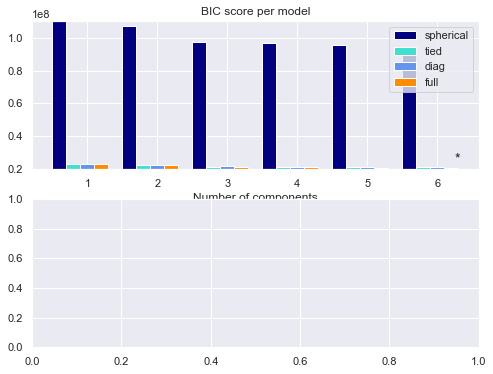

In [37]:
X=offline
Y=online
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(Y)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = np.linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [34]:
locCounts = pd.crosstab(offline.posX, offline.posY)
locCounts.transpose()
# Note 880 recordings at each location compared to ~5500 in text.

posX,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
posY,,,,,,,,,,,,,,,,,,,,,
0,880,880,880,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,880,880,880,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,880,880,880,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,880,880,880,880,880,880,880,880,880,880,...,880,880,880,880,880,880,880,880,880,880
4,880,880,880,0,0,0,0,0,0,878,...,880,880,880,0,0,0,0,0,880,880
5,0,880,880,0,0,0,0,0,0,0,...,880,0,880,0,0,0,0,0,880,0
6,0,880,880,0,0,0,0,0,0,0,...,880,0,880,0,0,0,0,0,880,0
7,880,880,880,880,880,880,880,880,880,880,...,880,880,880,880,880,880,880,880,880,880
8,880,880,880,880,880,880,880,880,880,880,...,880,880,880,880,880,880,880,880,880,880


## kNN Implementation

In [359]:
import math

# Choose between addresses used in training subset
def cd():
    return [3, 5, 6, 7, 8, 9]

def c0():
    return [4, 5, 6, 7, 8, 9]

def both():
    return [3, 4, 5, 6, 7, 8, 9]

addressSwitcher = {
    'cd': cd,
    'c0': c0,
    'both': both
}

def addressSwitch(macID):
    return addressSwitcher.get(macID)()

# Average of the nearest neighbors
def averagePosition(neighbors, k):
    '''Performs unweighted averages on k nearest neighbors'''
    # Unweighted averages
    estX = neighbors['posX'].iloc[0:k].mean()
    estY = neighbors['posY'].iloc[0:k].mean()
    return (estX, estY)

def findNN(testpoint, trainSubset, macID, k):
    '''Subsets by macID and sorts by distance'''
    # Calculate signal differences at addresses
    diffs = trainSubset.iloc[:, addressSwitch(macID)].apply(lambda x: x - testpoint, axis=1)
    # Euclidean distance
    if macID == 'c0':
        diffs = diffs.drop('00:0f:a3:39:dd:cd', axis=1)
        dists = diffs.iloc[:, 0:6].apply(lambda x: math.sqrt(sum(x**2)), axis=1)
    elif macID == 'cd':
        diffs = diffs.drop('00:0f:a3:39:e1:c0', axis=1)
        dists = diffs.iloc[:, 0:6].apply(lambda x: math.sqrt(sum(x**2)), axis=1)
    else:
        dists = diffs.iloc[:, 0:7].apply(lambda x: math.sqrt(sum(x**2)), axis=1)
    neighbors = trainSubset.copy()
    neighbors['dists'] = dists
    neighbors.sort_values(by='dists', inplace=True)
    return averagePosition(neighbors, k)

In [370]:
# Test zone

# Working example, obtain random test point from online test set.
import random
testpoint = online.iloc[random.randint(0, len(online)-1)]
testpoint

# Subset offline to match orientations of test point. 
# CAN BE SUBSETTED FURTHER FOR RAPID TESTING
trainSubset = offline[offline['orientation'] == testpoint['orientation']]
#trainSubset = trainSubset.iloc[0:1000]

In [371]:
# Call findNN() to get an estimated position. macID takes 'c0', 'cd', or 'both'.
# General format: estimate = findNN(testpoint, trainSubset, 'cd', 15)
estXYcd = findNN(testpoint, trainSubset, 'cd', 15)
estXYc0 = findNN(testpoint, trainSubset, 'c0', 15)
estXYboth = findNN(testpoint, trainSubset, 'both', 15)

# Basic Euclidean error
# Currently in triplicate on cd, c0, and including both to verify estimates and errors actually differ.
errorcd = math.sqrt((testpoint['posX']-estXYcd[0])**2 + (testpoint['posY']-estXYcd[1])**2)
errorc0 = math.sqrt((testpoint['posX']-estXYc0[0])**2 + (testpoint['posY']-estXYc0[1])**2)
errorboth = math.sqrt((testpoint['posX']-estXYboth[0])**2 + (testpoint['posY']-estXYboth[1])**2)
print('Test coordinates: ({}, {}).)'.format(testpoint['posX'], testpoint['posY']))
print('cd Estimate: {}.\ncd Error: {}'.format(estXYcd, errorcd))
print('c0 Estimate: {}.\nc0 Error: {}'.format(estXYc0, errorc0))
print('Both Estimate: {}.\nBoth Error: {}'.format(estXYboth, errorboth))

Test coordinates: (0.31, 11.090000000000002).)
cd Estimate: (0.6, 10.4).
cd Error: 0.7484650960465703
c0 Estimate: (0.3333333333333333, 10.533333333333333).
c0 Error: 0.5571554740126172
Both Estimate: (0.6, 10.2).
Both Error: 0.9360555539069271
